In [2]:
from bo_utils.bo_excel_to_csv import export_excel_to_csv, export_bounds_from_config
from config import COLUMNS_CONFIG, BOUNDS
import pandas as pd

export_excel_to_csv(
    "orthogonal_samplesI.xlsx",
    sheet_name="Experiments",
    csv_file="experiments.csv",
    log_file="experiment_log.csv",
    columns_config=COLUMNS_CONFIG,
)

# Exportiere einmalig deine Bounds aus Excel zu CSV
export_bounds_from_config(bounds=BOUNDS,  output_csv='bounds.csv')

Exporting data from orthogonal_samplesI.xlsx [Experiments] to experiments.csv...
[DEBUG] Using target: yield_loi
Export complete! Rows: 15
Meta info logged to: experiment_log.csv
Bounds successfully exported to: bounds.csv


In [2]:
from config import CSV_FILE, BOUNDS_CSV, COLUMNS_CONFIG
from bo_utils.bo_data import (
    load_csv_experiment_data,
    load_bounds_csv,
    prepare_training_data
)

# Load experiment data from CSV
raw_inputs, raw_outputs, df = load_csv_experiment_data(CSV_FILE, columns_config=COLUMNS_CONFIG)
print("Raw inputs shape:", raw_inputs.shape)
print("Raw outputs shape:", raw_outputs.shape)
print("DataFrame shape:", df.shape)

# Load parameter bounds from CSV
bounds = load_bounds_csv(BOUNDS_CSV)

# Prepare scaled training data
scaled_x, scaled_y = prepare_training_data(raw_inputs, raw_outputs, bounds)

# Determine input dimension dynamically
input_dim = scaled_x.shape[1]
print(scaled_y)

Reading experiment data from: experiments.csv
[DEBUG] Auto-detected output column: Conversion [%]
[DEBUG] Dropping NaN rows for output column 'Conversion [%]'
[DEBUG] Using input columns: ['Temperature [°C]', 'Reaction Time [min]', 'CaO [w%]', 'CaCl2 [w%]']
[DEBUG] Using output column: Conversion [%]
Loaded 17 experiments with 4 parameters.
Raw inputs shape: (17, 4)
Raw outputs shape: (17,)
DataFrame shape: (17, 5)
Loaded parameter bounds:
Param 1: [100.0, 200.0]
Param 2: [30.0, 180.0]
Param 3: [0.0, 2.0]
Param 4: [0.0, 0.45414]
[0.42015207 0.2536     0.29445518 0.22136179 0.31378121 0.37221018
 0.36434045 0.24382789 0.25159525 0.19421676 0.30698268 0.36919545
 0.47720583 0.29101211 0.39733069 0.41219647 0.42688352]


In [3]:
from bo_utils.bo_model import build_gp_model, fit_model, prepare_training_tensors
from config import INPUT_DIM
from config import MODEL_CONFIG
INPUT_DIM = scaled_x.shape[1] if INPUT_DIM != scaled_x.shape[1] else INPUT_DIM
train_x, train_y = prepare_training_tensors(scaled_x, scaled_y)
#print(train_x)
model, likelihood = build_gp_model(train_x, train_y, INPUT_DIM, MODEL_CONFIG)
fit_model(model)


# # Lengthscale
print("Lengthscale:", model.covar_module.base_kernel.lengthscale.detach().cpu().numpy())

# noise_param = model.likelihood.raw_noise

# if hasattr(noise_param, "prior") and noise_param.prior is not None:
#     print("Noise Prior:", noise_param.prior)
#     print("Noise Prior Bound (lower):", noise_param.prior.base_constraint.lower_bound)
# else:
#     print("Noise Prior: None")

Training data shapes: X=torch.Size([17, 4]), Y=torch.Size([17, 1])
Model fitting complete.
Lengthscale: [[0.35031701 0.31976016 1.26911749 0.34959869]]


In [4]:
from sklearn.metrics import mean_squared_error
from bo_utils.bo_model import build_gp_model, fit_model
from bo_utils.bo_validation import loocv_gp_custom
import torch

# === Modelltraining mit allen Daten ===
model_full, likelihood_full = build_gp_model(train_x, train_y, input_dim, MODEL_CONFIG)
fit_model(model_full)

model_full.eval()
likelihood_full.eval()

with torch.no_grad():
    posterior_full = model_full.posterior(train_x)
    mean_preds_train = posterior_full.mean.squeeze()

# === Trainingsfehler (auf denselben Daten) ===
train_mse = mean_squared_error(train_y.squeeze().numpy(), mean_preds_train.numpy())
print(f"Training MSE: {train_mse:.6f}")

# === LOOCV-MSE (realistische Schätzung) ===
_, _, loocv_mse, _ = loocv_gp_custom(train_x, train_y, input_dim, model_config=MODEL_CONFIG)
print(f"LOOCV MSE: {loocv_mse:.6f}")

Model fitting complete.
Training MSE: 0.000000
LOOCV iteration 1/17
LOOCV iteration 2/17
LOOCV iteration 3/17
LOOCV iteration 4/17
LOOCV iteration 5/17
LOOCV iteration 6/17
LOOCV iteration 7/17
LOOCV iteration 8/17
LOOCV iteration 9/17
LOOCV iteration 10/17
LOOCV iteration 11/17
LOOCV iteration 12/17
LOOCV iteration 13/17
LOOCV iteration 14/17
LOOCV iteration 15/17
LOOCV iteration 16/17
LOOCV iteration 17/17

LOOCV Mean Squared Error: 0.0051
Average Learned Noise: 0.001502
LOOCV MSE: 0.005056


In [6]:
print("Learned noise (var):", likelihood.noise.item())
print("Std dev:", likelihood.noise.sqrt().item())

Learned noise (var): 0.001502441364211864
Std dev: 0.03876133852451259


In [8]:
import torch
model.eval()
model.likelihood.eval()

with torch.no_grad():
    # Posterior mit Noise
    full_posterior = model.posterior(train_x)
    full_mean = full_posterior.mean
    full_std = full_posterior.variance.sqrt()

    # Posterior ohne Noise (latenter GP)
    latent_posterior = model(train_x)
    latent_mean = latent_posterior.mean
    latent_std = latent_posterior.variance.sqrt()

# Ausgabe pro Trainingspunkt
print(f"{'Idx':>4} | {'Mean':>8} | {'Std (with noise)':>18} | {'Std (latent)':>14}")
print("-" * 55)
for i in range(train_x.shape[0]):
    print(f"{i:>4} | {full_mean[i].item():8.4f} | {full_std[i].item():18.4f} | {latent_std[i].item():14.4f}")

 Idx |     Mean |   Std (with noise) |   Std (latent)
-------------------------------------------------------
   0 |   0.4200 |             0.0032 |         0.0387
   1 |   0.2539 |             0.0032 |         0.0387
   2 |   0.2945 |             0.0032 |         0.0387
   3 |   0.2213 |             0.0032 |         0.0386
   4 |   0.3137 |             0.0032 |         0.0386
   5 |   0.3721 |             0.0032 |         0.0387
   6 |   0.3646 |             0.0032 |         0.0386
   7 |   0.2439 |             0.0032 |         0.0386
   8 |   0.2517 |             0.0032 |         0.0387
   9 |   0.1944 |             0.0032 |         0.0386
  10 |   0.3070 |             0.0032 |         0.0386
  11 |   0.3692 |             0.0032 |         0.0387
  12 |   0.4769 |             0.0032 |         0.0387
  13 |   0.2912 |             0.0032 |         0.0386
  14 |   0.3973 |             0.0032 |         0.0387
  15 |   0.4120 |             0.0032 |         0.0387
  16 |   0.4266 |         

In [9]:
model.eval()
likelihood.eval()

with torch.no_grad():
    posterior = model.posterior(train_x)
    latent_std = posterior.variance.sqrt()

    predictive = likelihood(model(train_x))
    predictive_std = predictive.variance.sqrt()

for i in range(train_x.shape[0]):
    print(f"{i:4d} |  {posterior.mean[i].item():8.4f} |  {predictive_std[i].item():12.4f} |  {latent_std[i].item():12.4f}")

   0 |    0.4200 |        0.0548 |        0.0032
   1 |    0.2539 |        0.0548 |        0.0032
   2 |    0.2945 |        0.0548 |        0.0032
   3 |    0.2213 |        0.0547 |        0.0032
   4 |    0.3137 |        0.0547 |        0.0032
   5 |    0.3721 |        0.0547 |        0.0032
   6 |    0.3646 |        0.0547 |        0.0032
   7 |    0.2439 |        0.0547 |        0.0032
   8 |    0.2517 |        0.0547 |        0.0032
   9 |    0.1944 |        0.0547 |        0.0032
  10 |    0.3070 |        0.0547 |        0.0032
  11 |    0.3692 |        0.0548 |        0.0032
  12 |    0.4769 |        0.0547 |        0.0032
  13 |    0.2912 |        0.0547 |        0.0032
  14 |    0.3973 |        0.0548 |        0.0032
  15 |    0.4120 |        0.0548 |        0.0032
  16 |    0.4266 |        0.0547 |        0.0032


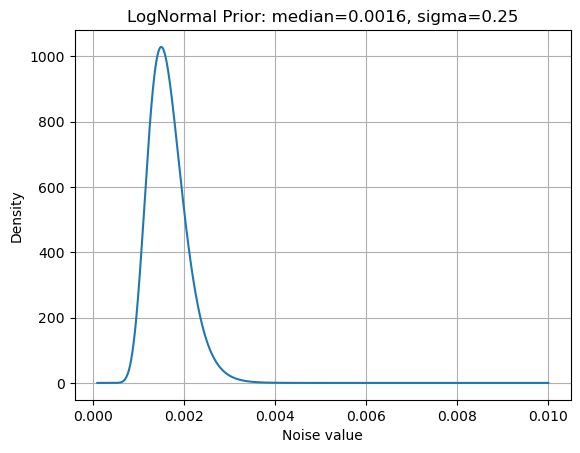

In [5]:
from scipy.stats import lognorm
import matplotlib.pyplot as plt
import numpy as np

mu = np.log(0.0016)
sigma = 0.25

x = np.linspace(0.0001, 0.01, 1000)
pdf = lognorm.pdf(x, s=sigma, scale=np.exp(mu))

plt.plot(x, pdf)
plt.title("LogNormal Prior: median=0.0016, sigma=0.25")
plt.xlabel("Noise value")
plt.ylabel("Density")
plt.grid(True)
plt.show()

In [6]:
from bo_utils.bo_optimization import optimize_posterior_mean, optimize_qEI
import numpy as np
from config import BATCH_SIZE
best_x_scaled = optimize_posterior_mean(model, INPUT_DIM)
from botorch.acquisition.utils import prune_inferior_points
x_baseline = prune_inferior_points(model, train_x)
best_f = train_y.max().item()
limit = -2
cand = optimize_qEI(model=model, input_dim=INPUT_DIM, best_f=best_f, batch_size=BATCH_SIZE, limit=limit, x_baseline=train_x, acquisition_type="qNEI")

Best x (scaled): tensor([[0.5089, 1.0000, 0.5409, 0.6699]])
Candidates (scaled):
tensor([[0.4811, 1.0000, 0.1116, 0.8043],
        [0.5544, 1.0000, 0.3825, 0.6152],
        [1.0000, 0.2782, 0.5966, 0.0000]], dtype=torch.float64)


In [13]:
from bo_utils.bo_utils import rescale_single_point, rescale_batch

best_x = rescale_single_point(best_x_scaled.detach().cpu().numpy()[0], bounds)
print("Best (rescaled):", best_x)

x_next = rescale_batch(cand, bounds)
print("Next candidates (rescaled):", x_next)

Best (rescaled): [150.88725686 180.           1.45855057   0.30421185]
Next candidates (rescaled): [[145.61180177 180.           1.2689189    0.37276044]
 [155.90799285 180.           0.80218799   0.29721135]
 [155.8308009  164.12169893   1.28801157   0.25507047]]


In [6]:
from bo_utils.bo_save_csv import append_candidates_to_csv

append_candidates_to_csv(
    candidates_list=x_next,
    csv_file="experiments.csv",
    max_objective=best_f,
    n_existing_points=len(train_x),
    log_file="experiment_log.csv"
)

Appended 3 candidates to experiments.csv
Meta info logged to: experiment_log.csv


In [7]:
from bo_utils.bo_save_csv import save_candidates_to_new_csv



save_candidates_to_new_csv(
    candidates_list=x_next,
    max_objective=best_f
)

Saved candidates to candidates_2025-05-10.csv


In [14]:
from bo_utils.bo_validation import loocv_gp_custom 
from bo_utils.bo_validation import log_loocv_result
from config import MODEL_CONFIG

preds, truths, mse, noise = loocv_gp_custom(train_x, train_y, input_dim, MODEL_CONFIG)

log_loocv_result(
    log_file="loocv_results_log.csv",
    model_name=MODEL_CONFIG["name"],
    input_dim=input_dim,
    kernel_type=MODEL_CONFIG["kernel_type"],
    noise_prior_range=MODEL_CONFIG["noise_prior_range"],
    ard=MODEL_CONFIG["ard"],
    mse=mse,
    num_points=len(train_x),
    prior = MODEL_CONFIG.get("lengthscale_prior", None),
    prior_lengthscale=MODEL_CONFIG["lengthscale_prior_params"],
    noise_value = noise,
    notes="Test with new kernel config"
)

LOOCV iteration 1/17
LOOCV iteration 2/17
LOOCV iteration 3/17
LOOCV iteration 4/17
LOOCV iteration 5/17
LOOCV iteration 6/17
LOOCV iteration 7/17
LOOCV iteration 8/17
LOOCV iteration 9/17
LOOCV iteration 10/17
LOOCV iteration 11/17
LOOCV iteration 12/17
LOOCV iteration 13/17
LOOCV iteration 14/17
LOOCV iteration 15/17
LOOCV iteration 16/17
LOOCV iteration 17/17

LOOCV Mean Squared Error: 0.0051
Average Learned Noise: 0.000400
Logged LOOCV result to loocv_results_log.csv


In [9]:
import torch
import copy
from bo_utils.bo_validation import loocv_gp_custom, log_loocv_result

# Annahme: du hast diese Variablen schon gesetzt:
# train_x, train_y = deine Trainingsdaten
# input_dim = train_x.shape[1]
N_TRAIN = train_x.shape[0]

# Build grid of tests
test_configs = []

# Beispiel: Matern-Kernel mit verschiedenen nu & ARD & Priors
for kernel_nu in [2.5, 1.5, 0.5]:
    for ard in [True, False]:
        for prior_type, prior_params in [
            (None, None),
            ("Gamma", (1.1, 0.05))
        ]:
            config = {
                "name": f"GP_Matern_{kernel_nu}",
                "kernel_type": "Matern",
                "kernel_nu": kernel_nu,
                "ard": ard,
                "noise_prior_range": (0.0001, 0.2),
                "prior_type": prior_type,
                "prior_params": prior_params
            }
            test_configs.append(config)

# Beispiel: RBF-Kernel auch testen
for ard in [True, False]:
    for prior_type, prior_params in [
        (None, None),
        ("Gamma", (1.1, 0.05))
    ]:
        config = {
            "name": "GP_RBF",
            "kernel_type": "RBF",
            "kernel_nu": None,  # irrelevant für RBF
            "ard": ard,
            "noise_prior_range": (0.0001, 0.2),
            "prior_type": prior_type,
            "prior_params": prior_params
        }
        test_configs.append(config)

# Jetzt durch die Tests loopen
for config in test_configs:
    print(f"Running: {config}")

    # Run LOOCV für diese Config
    preds, truths, mse_value, avg_noise = loocv_gp_custom(
    train_x, train_y, input_dim,
    verbose=False,
    model_config=config
    )
    
    # Log die Ergebnisse
    log_loocv_result(
        log_file="loocv_results_log.csv",
        model_name=config["name"],
        input_dim=input_dim,
        kernel_type=config["kernel_type"],
        noise_prior_range=config["noise_prior_range"],
        mse=mse_value,
        ard=config["ard"],
        num_points=N_TRAIN,
        prior=config["prior_type"] or "",
        prior_lengthscale=config["prior_params"] or "",
        noise_value=avg_noise,
        notes="Automated grid search"
    )

Running: {'name': 'GP_Matern_2.5', 'kernel_type': 'Matern', 'kernel_nu': 2.5, 'ard': True, 'noise_prior_range': (0.0001, 0.2), 'prior_type': None, 'prior_params': None}

LOOCV Mean Squared Error: 0.0016
Average Learned Noise: 0.000100
Logged LOOCV result to loocv_results_log.csv
Running: {'name': 'GP_Matern_2.5', 'kernel_type': 'Matern', 'kernel_nu': 2.5, 'ard': True, 'noise_prior_range': (0.0001, 0.2), 'prior_type': 'Gamma', 'prior_params': (1.1, 0.05)}

LOOCV Mean Squared Error: 0.0016
Average Learned Noise: 0.000100
Logged LOOCV result to loocv_results_log.csv
Running: {'name': 'GP_Matern_2.5', 'kernel_type': 'Matern', 'kernel_nu': 2.5, 'ard': False, 'noise_prior_range': (0.0001, 0.2), 'prior_type': None, 'prior_params': None}

LOOCV Mean Squared Error: 0.0018
Average Learned Noise: 0.000100
Logged LOOCV result to loocv_results_log.csv
Running: {'name': 'GP_Matern_2.5', 'kernel_type': 'Matern', 'kernel_nu': 2.5, 'ard': False, 'noise_prior_range': (0.0001, 0.2), 'prior_type': 'Gamma'

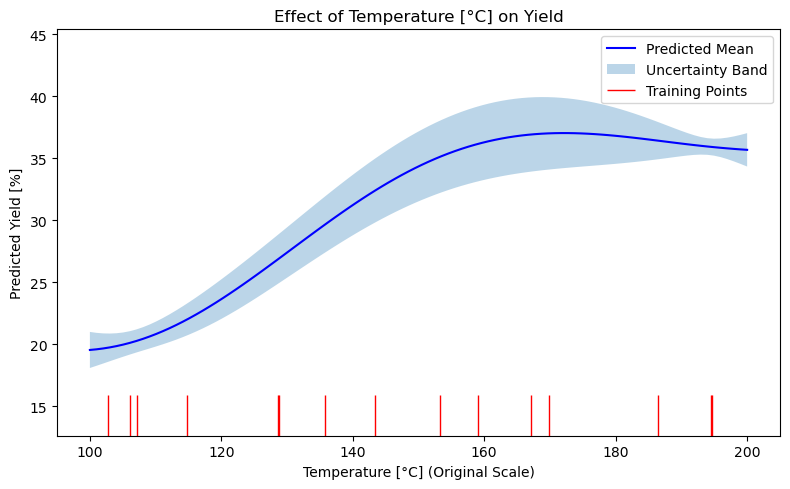

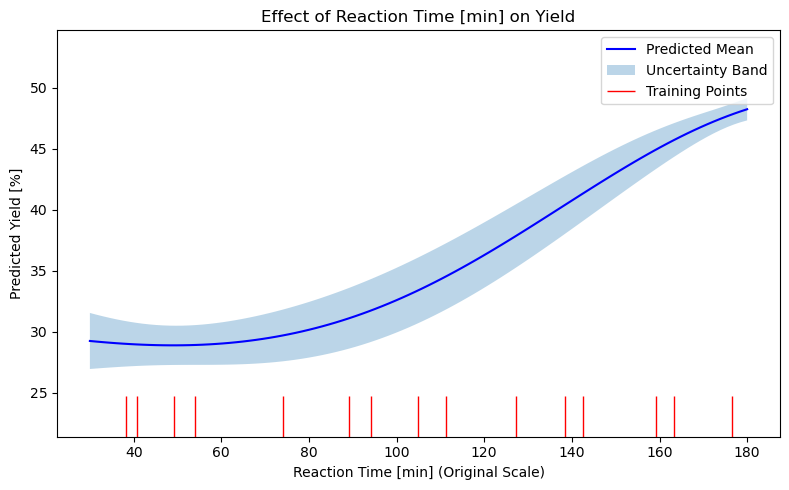

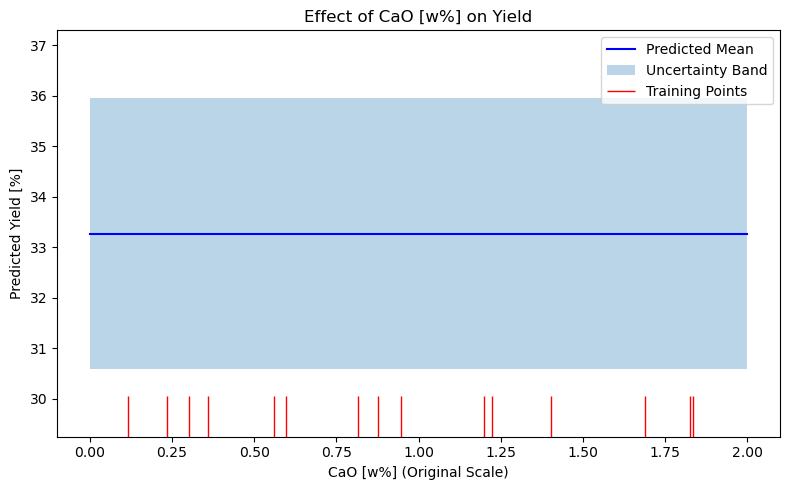

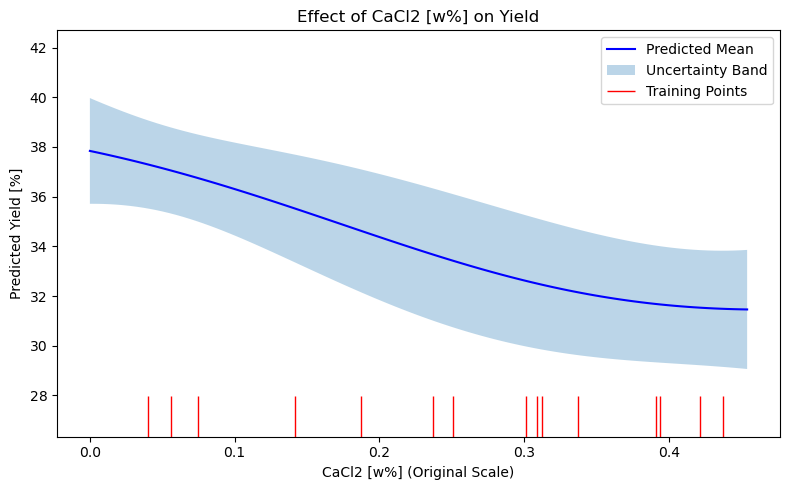

In [6]:
from bo_utils.bo_plotting import plot_posterior_slices
from config import COLUMNS_CONFIG
import warnings
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")
%matplotlib inline
param_names = [
    v for k, v in COLUMNS_CONFIG.items() if not k.startswith("yield")
]

plot_posterior_slices(
    model,
    train_x,
    bounds,
    param_names=param_names
)

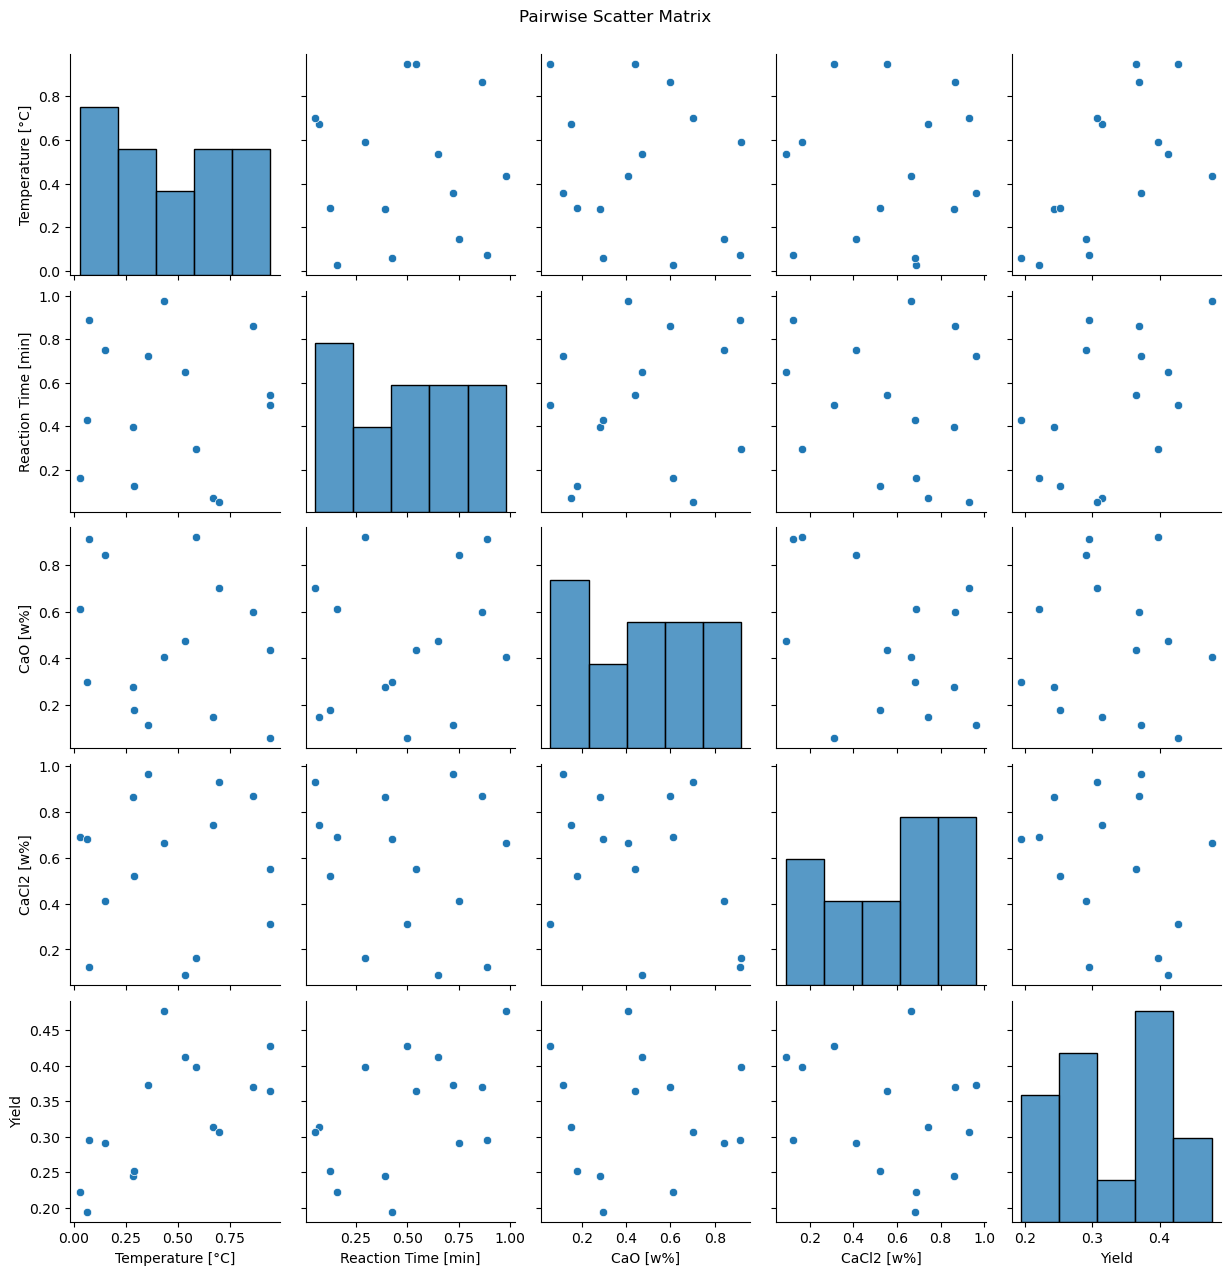

In [11]:
from bo_utils.bo_plotting import plot_pairwise
import pandas as pd
import numpy as np

param_names = [
    v for k, v in COLUMNS_CONFIG.items() if not k.startswith("yield")
]
df_plot = pd.DataFrame(
    np.hstack([scaled_x, scaled_y.reshape(-1, 1)]),
    columns=param_names + ["Yield"]
)
plot_pairwise(df_plot)

In [12]:
from bo_utils.bo_plotting import plot_3d_scatter_interactive


plot_3d_scatter_interactive(
    raw_inputs,
    raw_outputs,
    param_x_idx=0,  # Temperature
    param_y_idx=3,  # CaCl2 mass
    param_names=param_names,
    filename="3d_scatter_temperature_cacl2.html"
)

Interactive plot saved as 3d_scatter_temperature_cacl2.html


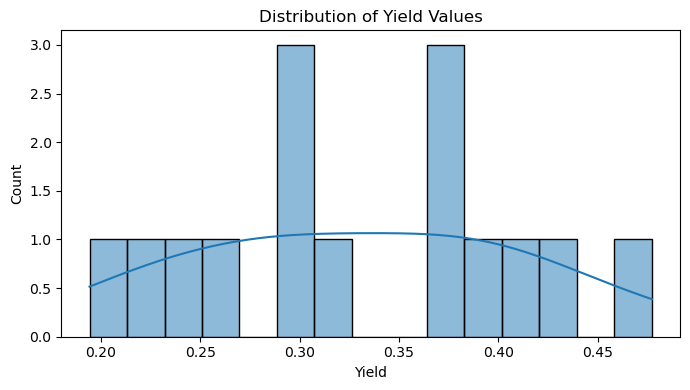

In [13]:
from bo_utils.bo_plotting import plot_yield_distribution

plot_yield_distribution(raw_outputs)

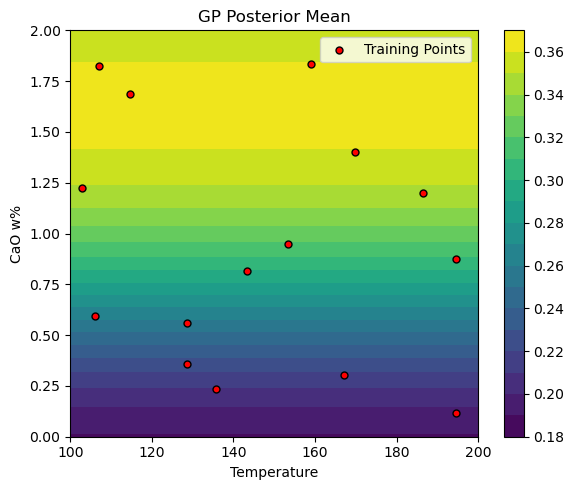

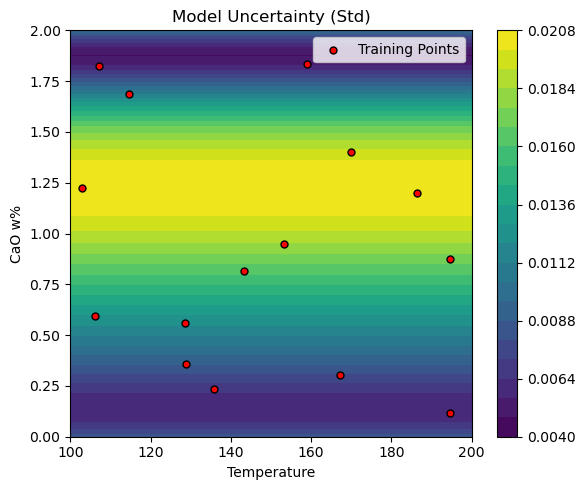

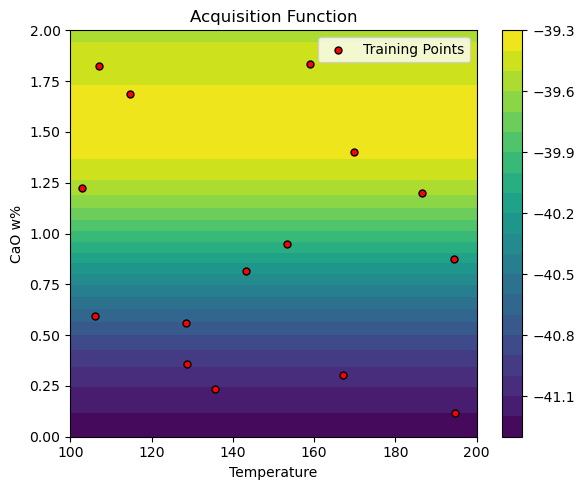

Interactive HTML plot saved as gp_posterior_temperature_cao.html


In [ ]:
from bo_utils.bo_plotting import plot_2d_bo_contours
from botorch.acquisition import qLogExpectedImprovement
from botorch.acquisition import qLogNoisyExpectedImprovement

plot_2d_bo_contours(
    model,
    train_x,
    train_y,
    bounds,
    param_x_idx= 0,
    param_y_idx=2,
    param_names=["Temperature", "Reaction Time", "CaO w%", "CaCl2 w%"],
    #acquisition_func_factory=lambda model: qLogExpectedImprovement(model, best_f=train_y.max().item()),
    acquisition_func_factory=lambda model: qLogNoisyExpectedImprovement(model, X_baseline=train_x),
    save_html=True,
    html_filename="gp_posterior_temperature_cao.html"
)